# A Data-Based Understanding of Political Revolutions
Political upheavals have been ever present throughout humanity. Political leaders shape the context for everything we know. For that reason, we as a society need to generate a concrete understanding of when a revolution or political change is imminent. This analysis seeks to forecast whether a given protest will lead to a revolution within 90 days. 

The stakeholders for this analysis are wide reaching, but it is most relevant to political organizers and leadership. They can use this approach to best understand where efforts are best focused and most likely to lead to an impact. 

We as a society have only begun to establish the collection of data necessary to make these analyses feasible, but we have crossed the threshold of significance beyond which there is substantial merit in this project. 

## Notebook Structure
1. Data & Sources
2. xxx
3. xxx
4. xxx




## Part I. Data & Sources
The analysis combines three core datasets from widely different sources to provide a distinctly unique understanding of the subject. They are described below.

#### The Mass Mobilization Project

The first dataset, used as the center of the analysis, is incredibly valuable. It is described in the source documentation as *"an effort to understand citizen movements against governments, what citizens want when they demonstrate against governments, and how governments respond to citizens. The MM data cover 162 countries between 1990 and 2018. These data contain events where 50 or more protesters publicly demonstrate against government, resulting in more than 10,000 protest events. Each event records location, protest size, protester demands, and government responses."* [(1)](https://massmobilization.github.io/about.html) The project is sponsored by the Political Instability Task Force (PITF). The PITF is funded by the Central Intelligence Agency (CIA). [(1)](https://massmobilization.github.io/about.html) **Throughout this analysis, this dataset will be referred to as the "Protests" dataset.**

Although the data source does specify that the dataset is not entirely comprehensive of all country across this entire time period. That said, it does contain over 17,000 recorded protests, each composed of 31 features. The data span 167 countries from 1990 to 2020. 


##### Citation:

Clark, David; Regan, Patrick, 2016, "Mass Mobilization Protest Data", https://doi.org/10.7910/DVN/HTTWYL, Harvard Dataverse, V5, UNF:6:F/k8KUqKpCa5UssBbL/gzg== [fileUNF]

--------

#### The Polity Project
The second dataset is equally as valuable. It codes "authority characteristics of states in the world system for purposes of comparative, quantitative analysis." [(2)](https://www.systemicpeace.org/polityproject.html) "The Polity5 dataset covers all major, independent states in the global system over the period 1800-2018 (i.e., states with a total population of 500,000 or more in the most recent year; currently 167 countries. The Polity conceptual scheme is unique in that it examines concomitant qualities of democratic and autocratic authority in governing institutions, rather than discreet and mutually exclusive forms of governance. This perspective envisions a spectrum of governing authority that spans from fully institutionalized autocracies through mixed, or incoherent, authority regimes (termed "anocracies") to fully institutionalized democracies." [(2)](https://www.systemicpeace.org/polityproject.html). Most relevant to this analysis, "it also records changes in the institutionalized qualities of governing authority."  [(2)](https://www.systemicpeace.org/polityproject.html). These changes in governing authority are the target feature of this analysis. **Throughout this analysis, this dataset will be referred to as the "Regime Changes" or "Regimes" dataset.**

-------

#### The Database of Political Institutions

The third dataset is provided by the Inter-American Development Bank (IDB). "The Database of Political Institutions presents institutional and electoral results data such as measures of checks and balances, tenure and stability of the government, identification of party affiliation and ideology, and fragmentation of opposition and government parties in the legislature ... [it covers] about 180 countries [from] 1975-2020. It has become one of the most cited databases in comparative political economy and comparative political institutions, with more than 4,500 article citations on Google Scholar as of December 2020." [(3)](https://publications.iadb.org/en/database-political-institutions-2020-dpi2020)


##### Citation:

Cruz, Cesi, Philip Keefer, and Carlos Scartascini. 2021. Database of Political Institutions 2020.
Washington, DC: Inter-American Development Bank Research Department.

## Technical Notes
Given the large-scale nature of the project, this notebook inevitably does not contain the entire analysis. It does not go into depth on each of the choices made for feature selection or data cleaning. Consider this the "top level" notebook, and those more detail-oriented parts of the analysis are handled in their own spaces. Here is where you should go to find more details:


1. **[protests cleaning file name]:** Refer to this notebook for a ground-up analysis of the "Protests" dataset. It includes important features such as the nature of each protest (size, objectives, location, etc.). Especially exhaustive and detailed data cleaning choices are made in this notebook.
2. **[regime change file name]:** Refer to this notebook for a full study of the "Regime Change" data. Primarily, this data provides the target feature for the entire analysis: regime change. It indicates when are where political change occurs. Interesting feature engineering takes place here.
3. **[idb analysis file name]:** Refer to this notebook for an impressively comprehensive dataset surrounding descriptive attributes of governments around the world over many decades. Important information includes the political system of countries at specified times, the tenure of the country's primary leader, and the percentage of the popular vote the leader received (where relevant). There are descriptors as granular as the total number of seats in congress (where relevant). Extensive feature selection takes place in this notebook.

## Stage I. Data Preparation
[description]

In [1]:
# Basic imporrts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sqlalchemy import create_engine

# Model preprocessing and processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.base import clone

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Performance evaluation
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score
from sklearn.metrics import plot_confusion_matrix
import shap

# Display options
pd.options.display.max_columns = 200
%matplotlib inline

# Convenience for working with external .py files
%load_ext autoreload
%autoreload 2

# Convenience for working with external src code files
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../src')
from custom_plots import *
from create_target import *
from remove_missing_data import *
from evaluate_model_performance import *

# Global constants
RANDOM_STATE = 2021

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Import "Regime Change" dataset**

In [2]:
# Import cleaned database via SQL
engine = create_engine('sqlite:///../data/processed/regime_changes.db')
with engine.begin() as connection:
    df_regimes = pd.read_sql('SELECT * FROM regime_changes', con=connection)

# Type casting
df_regimes.startdate = pd.to_datetime(df_regimes.startdate)
df_regimes.enddate = pd.to_datetime(df_regimes.enddate)

**Import "Protests" dataset**

In [3]:
# Import cleaned database via SQL
engine = create_engine('sqlite:///../data/processed/protests.db')
with engine.begin() as connection:
    df_protests = pd.read_sql('SELECT * FROM protests', con=connection)

# Type casting
df_protests.startdate = pd.to_datetime(df_protests.startdate)

**Import "Government Characterization" dataset**

In [4]:
# Import cleaned database via SQL
engine = create_engine('sqlite:///../data/processed/governments.db')
with engine.begin() as connection:
    df_govts = pd.read_sql('SELECT * FROM governments', con=connection)

# Set index to be used in SQL join
df_govts.index = df_govts.year_scode

# Drop now-duplicated feature
df_govts.drop('year_scode', axis=1, inplace=True)

**Join "Protests" and "Government Characterization" datasets**

In [5]:
# Join both dataframes
df = df_protests.join(df_govts, how='left', on='year_scode')

**Remove features with missing values**

In [6]:
# Remove protests without corresponding "government"
df.dropna(inplace=True)

# Remove entries with limited "government" data
df = remove_missing_data(df)
#df.info()

**Join with "Regime Changes" dataset**

In [7]:
target = create_target(df, df_regimes)
df = pd.concat([df, target], axis=1)

**Basic Cleaning**

In [8]:
# Convert startdate to a float instead of datetime since datetime cannot be handled by models but fractional years can
df['startdate'] = df.startdate.dt.year + df.startdate.dt.month / 12 + df.startdate.dt.day / 365

# Define target as "regime change in less than 365 days"
target = (df['days_until_next_regime_chg'] < 365).astype('int')

# Drop unused columns
drop_columns = ['year_scode', 'scode_govt', 'country_govt', 'days_until_next_regime_chg', 'scode', 'participants_category', 'duration_days']
df.drop(drop_columns, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14561 entries, 0 to 15207
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            14561 non-null  object 
 1   region                             14561 non-null  object 
 2   protestnumber                      14561 non-null  int64  
 3   protesterviolence                  14561 non-null  int64  
 4   startdate                          14561 non-null  float64
 5   participants                       14561 non-null  int64  
 6   demand_labor-wage-dispute          14561 non-null  int64  
 7   demand_land-farm-issue             14561 non-null  int64  
 8   demand_police-brutality            14561 non-null  int64  
 9   demand_political-behavior/process  14561 non-null  int64  
 10  demand_price-increases/tax-policy  14561 non-null  int64  
 11  demand_removal-of-politician       14561 non-null  int

### Feature descriptions

Given the large number of features with abbreviated names, those that are used within the model are defined below.

Protest Details - as provided by *Protests* dataset:
- **country:** location of protest
- **region:** global region
- **protestnumber:** protest number in the selected country in a given year 
- **protesterviolence:** (y/n) indicator of protester violence
- **startdate:** first day of protest
- **participants:** number of individuals in attendance

---

Categorizations of the reason for a protest (multiple options possible) - as provided by *Protests* dataset:
-  **labor wage dispute** 
-  **land farm issue** 
-  **police brutality** 
-  **political behavior/process** 
-  **price increases/tax policy** 
-  **removal of politician** 
-  **social restrictions** 

---

Government descriptors in the given country at the time protest - as provided by *Government Characterization* dataset. Strict, quantifiable definitions are provided in Data Manual.

- **system:** governmental system (Parliamentary, Assembly-elected president, Presidential, Unelected)
- **yrsoffc:** number of years the chief executive has been in office
- **finittrm:** (y/n) is there a finite term in office?
- **military:** (y/n) is the chief executive a military officer?
- **totalseats:** total seats in the legislature
- **legelec:** (y/n) is there a legislative election in the protest year?
- **exelec:** (y/n) is there a executive election in the protest year?
- **liec:** legislative index of electoral competitiveness
- **eiec:** executive index of electoral competitiveness
- **gq:** are there gender quotas in government (None, Voluntary, Reserved, Required)
- **numvote:** total vote share of governmental leadership party
- **oppvote:** total vote share of all opposition parties
- **tensys_strict:** length of time the country has been autocratic or democratic
- **stabs_strict:** stability, as measured by the percent of veto players who *drop* from the government in a given year

---

Political regime authority characteristics - as provided by *Regime Changes* dataset. Strict, quantifiable definitions are provided in Data Manual.

- **parcomp:** competitiveness of political participation (Repressed, Suppressed, Factional, Transitional, Competitive)
- **parreg:** regulation of participation (Unregulated, Multiple Identity, Sectarian, Restricted, Regulated)
- **xconst:** executive constraints / decision rules (Unlimited Authority through Executive Parity)
- **xropen / xrcomp:** openness/competitiveness of executive recruitment (Closed, Designation, Election)
- **regime transition:** target feature for this analysis, quantified by a pre-specified level of change in above metrics. See data dictionary for in-depth technical definition of political regime transition. Note that the purpose of this analysis is not to define what a regime transition is, but rather to use existing definitions to best understand the circumstances under which they do occur.

## Modeling
[description]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14561 entries, 0 to 15207
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            14561 non-null  object 
 1   region                             14561 non-null  object 
 2   protestnumber                      14561 non-null  int64  
 3   protesterviolence                  14561 non-null  int64  
 4   startdate                          14561 non-null  float64
 5   participants                       14561 non-null  int64  
 6   demand_labor-wage-dispute          14561 non-null  int64  
 7   demand_land-farm-issue             14561 non-null  int64  
 8   demand_police-brutality            14561 non-null  int64  
 9   demand_political-behavior/process  14561 non-null  int64  
 10  demand_price-increases/tax-policy  14561 non-null  int64  
 11  demand_removal-of-politician       14561 non-null  int

**Create train-test split, as well as final holdout dataset**

In [10]:
# Create final holdout dataset
x_traintest, x_holdout, y_traintest, y_holdout = train_test_split(df, target, random_state=RANDOM_STATE)

# Create standard train-test splits
x_train, x_test, y_train, y_test = train_test_split(x_traintest, y_traintest, random_state=RANDOM_STATE)

**Create baseline "dummy" model**

In [11]:
# Create instance of dummy classifier and fit to training data
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(x_train, y_train)

# Create model predictions for test data
pred_dummy = dummy_clf.predict(x_test)
print_scores(pred_dummy, y_test)

- f1: 0.09983361064891846
- accuracy: 0.8018315018315019
- precision: 0.09615384615384616
- recall: 0.10380622837370242


**Create Logistic Regression classifier model**

In [12]:
# Instantiate model
model_log = LogisticRegression(max_iter=5000)

# Add one-hot encoding for categoricals
ohe = OneHotEncoder(handle_unknown='ignore')

# Add standard scaling
scaler = StandardScaler()

# Add resampling to address class imbalance
smote = SMOTE(random_state=RANDOM_STATE)


# Select object types for one-hot encoding and numeric types for scaling
selector_object = make_column_selector(dtype_include='object')
selector_numeric = make_column_selector(dtype_include='number')

# Create transformer for the selectors/encoders/scalers
transformer = make_column_transformer((ohe, selector_object),
                                     (scaler, selector_numeric))


# Create pipeline for transformer, resampling, and model
pipe = Pipeline([('transformer', transformer),
                 ('smote', smote), 
                 ('model', model_log)])

# Run grid search to optimizer hyperparameters
grid_log = {'model__C': np.logspace(-1, 5, 10)}
grid_search = GridSearchCV(pipe, grid_log, scoring='f1', cv=5)

# Fit model to training data
grid_search.fit(x_train, y_train);

**Create Random Forest model**

Reuse one-hot encoder, scaler, resampler, selectors, transformer from logistic regression

- f1: 0.6106870229007633
- accuracy: 0.9065934065934066
- precision: 0.546448087431694
- recall: 0.6920415224913494


<Figure size 432x288 with 0 Axes>

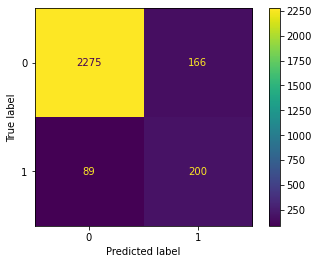

In [13]:
# Instantiate model
model_rf = RandomForestClassifier()

# 
# Create pipeline for transformer, resampling, and model
pipe = Pipeline([('transformer', transformer),
                 ('smote', smote), 
                 ('model', model_rf)])

# Run grid search to optimizer hyperparameters
grid_rf = {
    'model__n_estimators': [25, 75, 150],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 6, 10],
    'model__min_samples_split': [5, 10],
    'model__min_samples_leaf': [3, 6]}

# Create instance of grid search
grid_search = GridSearchCV(pipe, grid_rf, scoring='f1', cv=5)

# Fit model to training data
grid_search.fit(x_train, y_train)

# Evaluate performance
evaluate_model_performance(grid_search, x_test, y_test);

**XG Boost model**

- f1: 0.86654478976234
- accuracy: 0.9732600732600732
- precision: 0.9186046511627907
- recall: 0.8200692041522492


<Figure size 432x288 with 0 Axes>

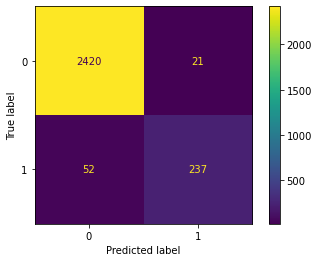

In [14]:
# Instantiate model
model_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_STATE)
# 
# Create pipeline for transformer, resampling, and model
pipe = Pipeline([('transformer', transformer),
                 ('smote', smote), 
                 ('model', model_xgb)])

# Run grid search to optimizer hyperparameters
grid_xgb = {
#    'model__learning_rate': [0.1, 0.25, 1],
#    'model__max_depth': [3, 5, 7, None],
#    'model__min_child_weight': [1, 2, None],
#    'model__subsample': [0.4, 0.6, 0.8, 1],
#    'model__n_estimators': [50, 100, 150],
    'model__tree_method': ['exact', 'approx', 'hist']}

# Create instance of grid search
grid_search = GridSearchCV(pipe, grid_xgb, scoring='f1', cv=5)

# Fit model to training data
grid_search.fit(x_train, y_train)

# Evaluate performance
final_model_xgb = evaluate_model_performance(grid_search, x_test, y_test)

## Evaluation
[description]

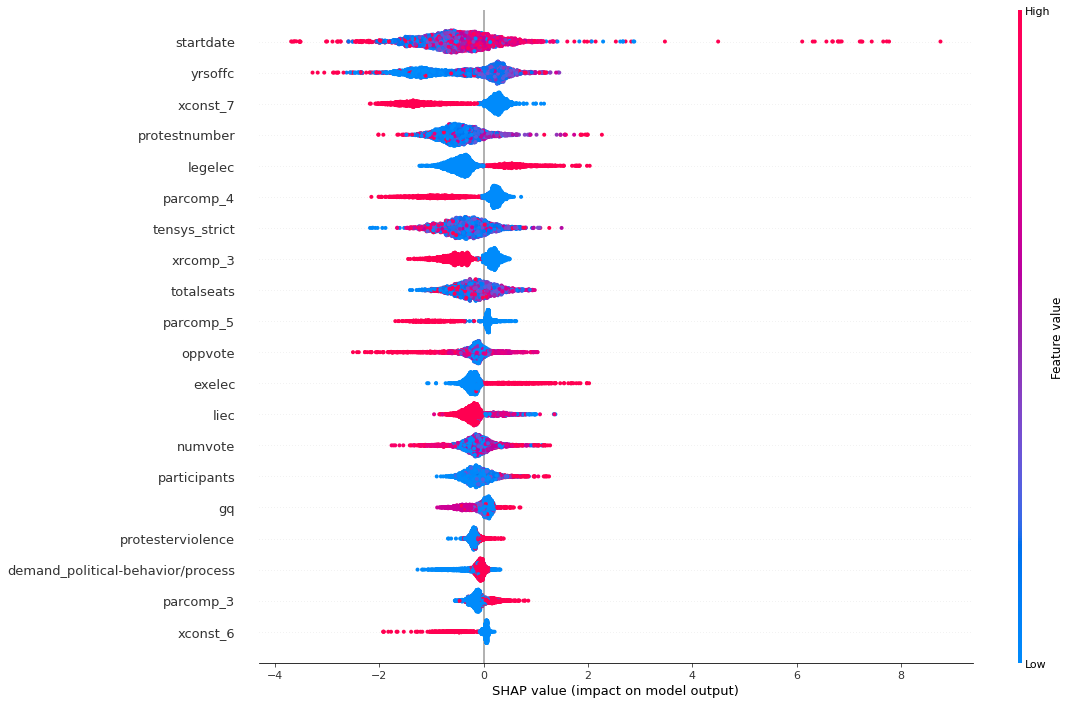

In [15]:
# SHAP plot for XGB
produce_shap_plot(x_train, y_train, x_test, y_test, clone(final_model_xgb));

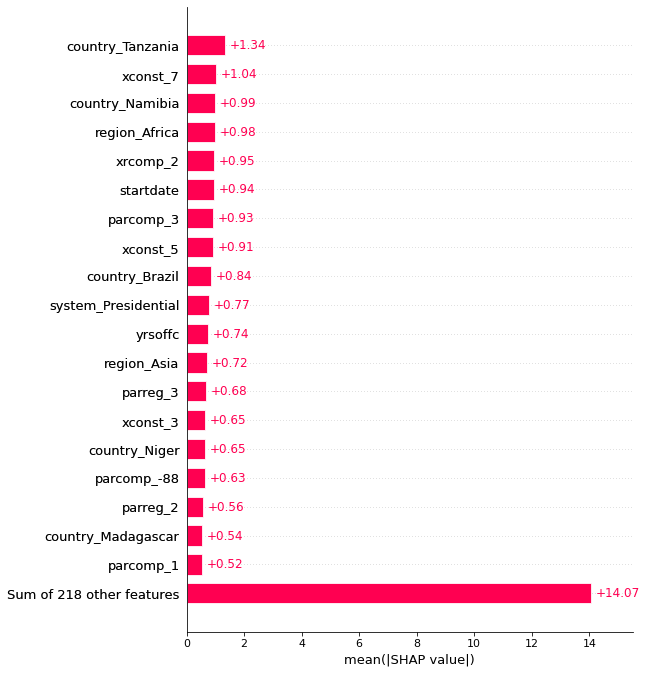

In [17]:
model_shap = final_model_xgb.steps[2][1]
x_train_final, y_train_final, df_test_expanded_scaled = get_shap_df(x_train, y_train, x_test)

explainer = shap.Explainer(model_shap)
shap_values = explainer(df_test_expanded_scaled)
shap.plots.bar(shap_values, max_display=20)

In [21]:
df_regimes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   country       1290 non-null   object        
 1   scode         1290 non-null   object        
 2   startdate     1290 non-null   datetime64[ns]
 3   enddate       1290 non-null   datetime64[ns]
 4   duration_yrs  1290 non-null   float64       
 5   parcomp       1290 non-null   int64         
 6   parreg        1290 non-null   int64         
 7   xconst        1290 non-null   int64         
 8   xropen        1290 non-null   int64         
 9   xrcomp        1290 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(5), object(2)
memory usage: 100.9+ KB


**Test performance on holdout data**

- f1: 0.875609756097561
- accuracy: 0.9719857182092831
- precision: 0.9111675126903553
- recall: 0.8427230046948356


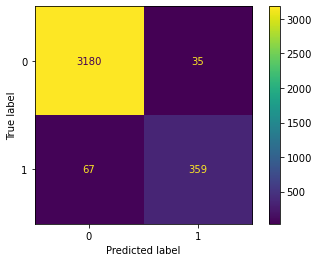

In [16]:
pred = final_model_xgb.predict(x_holdout)
print_scores(pred, y_holdout)

plot_confusion_matrix(final_model_xgb, x_holdout, y_holdout);

## Conclusion
[description]